In [1]:
# Librerías

import pandas as pd
import numpy as np
import nltk
from collections import Counter
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [2]:
# pip install scipy==1.10.1 
# Importante hacerlo con esta librería para que funcione

In [3]:
#nltk.download('punkt')
#nltk.download('stopwords')

# Corpus

In [4]:
# Cargo los datasets de las siguientes categorías

file_beauty = "/Beauty_5.json"
file_electronics = "/Electronics_5.json"
file_baby = "/Baby_5.json"

df_beauty = pd.read_json(file_beauty, lines=True)
df_electronics = pd.read_json(file_electronics, lines=True)
df_baby = pd.read_json(file_baby, lines=True)

# Voy a ver las primeras filas de uno de los datasets
df_beauty.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013"


In [5]:
# Voy a poner la categoría a cada dataset para saber a qué pertenece cada dato cuando los una

df_beauty['categoría'] = 'beauty'
df_electronics['categoría'] = 'electronics'
df_baby['categoría'] = 'baby'

In [6]:
# Ahora voy a clasificar las estrellas (columna overall)
# Un 0 para las que tienen 1 o 2 estrellas, considerando que son negativas
# Un 1 para las que tienen 3 o más, considerando que son positivas

def clasificacion_estrellas(overall):
    if overall <= 2:
        return 0  # Negativo
    elif overall >= 3:
        return 1  # Positivo

df_beauty['sentimiento'] = df_beauty['overall'].apply(clasificacion_estrellas)
df_electronics['sentimiento'] = df_electronics['overall'].apply(clasificacion_estrellas)
df_baby['sentimiento'] = df_baby['overall'].apply(clasificacion_estrellas)

In [7]:
# Voy a trabajar con subsets de cada dataframe, para ello, voy a ver primero las dimensiones

print(df_beauty.shape)
print(df_electronics.shape)
print(df_baby.shape)

(198502, 11)
(1689188, 11)
(160792, 11)


In [8]:
# Nos quedamos con 5000 reviews de sentimiento de cada dataset para agilizar nuestros cálculos

n_reviews = 5000

def subset_review(df, n_samples):
    return df.groupby('sentimiento', group_keys=False).apply(lambda x: x.sample(min(len(x), n_samples)))

# Aplicar la función a cada DataFrame
df_beauty = subset_review(df_beauty, n_reviews)
df_electronics = subset_review(df_electronics, n_reviews)
df_baby = subset_review(df_baby, n_reviews)


/var/folders/09/2b6953kn3w559xsdg6bctjbh0000gn/T/ipykernel_73918/1359232482.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sentimiento', group_keys=False).apply(lambda x: x.sample(min(len(x), n_samples)))
/var/folders/09/2b6953kn3w559xsdg6bctjbh0000gn/T/ipykernel_73918/1359232482.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sentimiento', group_keys=False).ap

In [9]:
# Comprobamos que tengan el mismo número de muestras
print(df_beauty.shape)
print(df_electronics.shape)
print(df_baby.shape)

(10000, 11)
(10000, 11)
(10000, 11)


In [10]:
# Concatenamos el dataset y obtenemos nuestro corpus para trabajar sobre él

df_corpus = pd.concat([df_beauty, df_electronics, df_baby])

# Análisis exploratorio (empiezo preproceso también)

## Cardinalidad del vocabulario

In [11]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation)) # quito signos de puntuación
    tokens = nltk.word_tokenize(text)
    
    return tokens

df_corpus['tokens'] = df_corpus['reviewText'].apply(preprocess_text)

vocabulario = Counter()
df_corpus['tokens'].apply(vocabulario.update)

# Calculo la cardinalidad del vocabulario (composición de tokens)
vocab_cardinalidad = len(vocabulario)

print("Cardinalidad del vocabulario:", vocab_cardinalidad, 'tokens')
print("Palabras más comunes:", vocabulario.most_common(10))

Cardinalidad del vocabulario: 76399 tokens
Palabras más comunes: [('the', 150472), ('i', 98634), ('and', 86823), ('to', 82796), ('it', 82261), ('a', 75107), ('is', 48126), ('this', 47363), ('of', 42496), ('my', 39720)]


## Distribución de reviews por número de estrellas

overall
1    7573
2    7427
3    1709
4    3456
5    9835
Name: count, dtype: int64


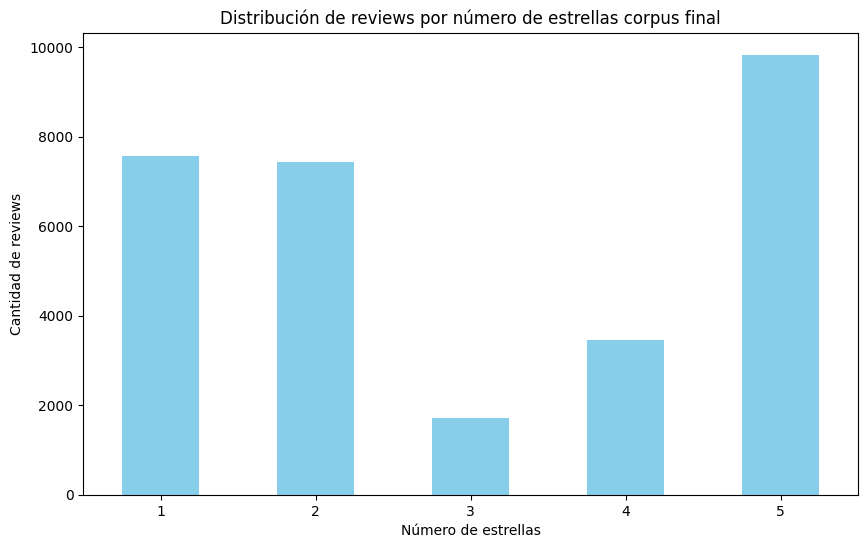

In [12]:
stars_distribution = df_corpus['overall'].value_counts().sort_index()
print(stars_distribution)

plt.figure(figsize=(10, 6))
stars_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribución de reviews por número de estrellas corpus final')
plt.xlabel('Número de estrellas')
plt.ylabel('Cantidad de reviews')
plt.xticks(rotation=0)
plt.show()

overall         1     2    3     4     5
categoría                               
baby         2267  2733  597  1140  3263
beauty       2425  2575  626  1155  3219
electronics  2881  2119  486  1161  3353


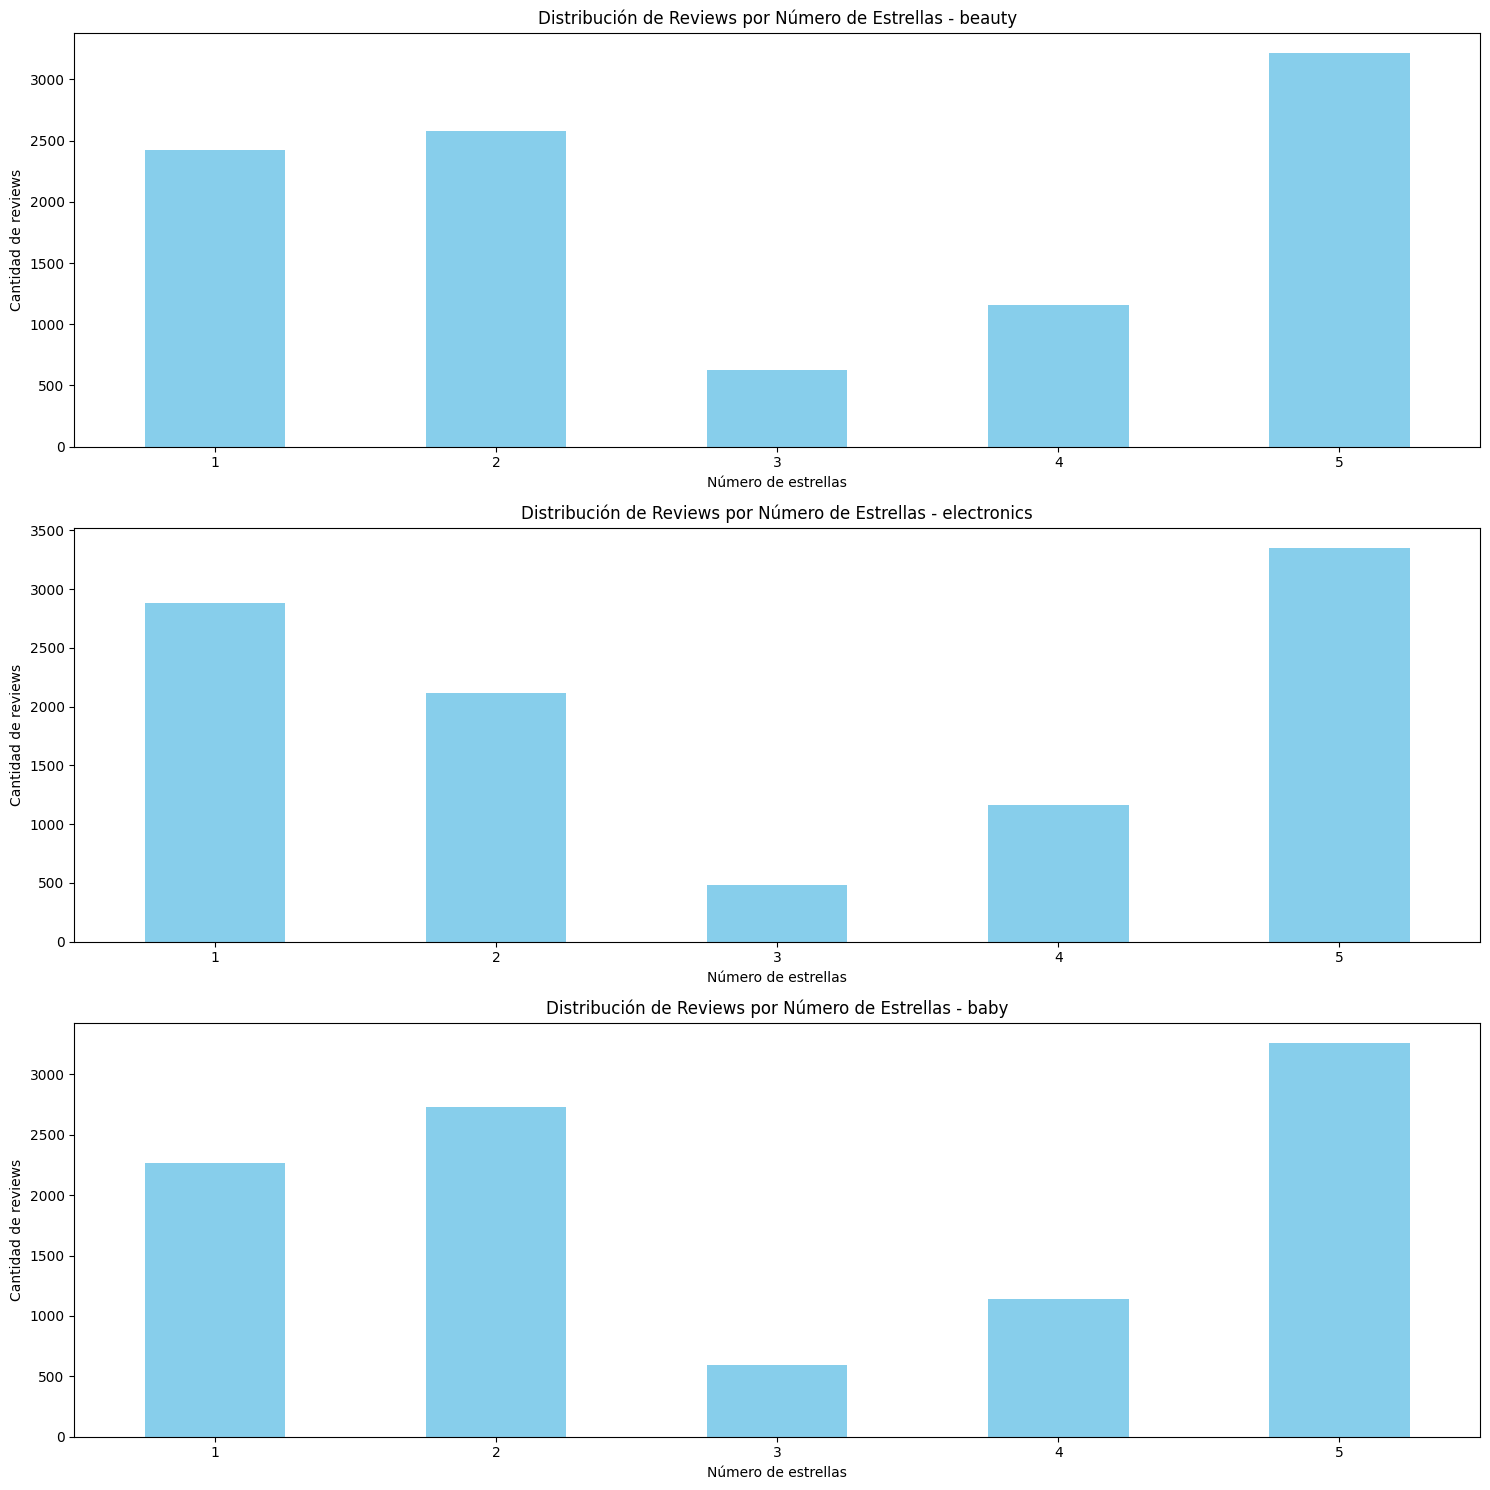

In [13]:
# Para cada categoría

distribucion_estrellas_categoria = df_corpus.groupby(['categoría', 'overall']).size().unstack(fill_value=0)
print(distribucion_estrellas_categoria)

categories = df_corpus['categoría'].unique()
num_categories = len(categories)

plt.figure(figsize=(15, 5 * num_categories))

for i, category in enumerate(categories):
    plt.subplot(num_categories, 1, i + 1)
    distribucion_estrellas_categoria.loc[category].plot(kind='bar', color='skyblue')
    plt.title(f'Distribución de Reviews por Número de Estrellas - {category}')
    plt.xlabel('Número de estrellas')
    plt.ylabel('Cantidad de reviews')
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## Nº de reviews positivas y negativas

Negativa    15000
Positiva    15000
Name: count, dtype: int64


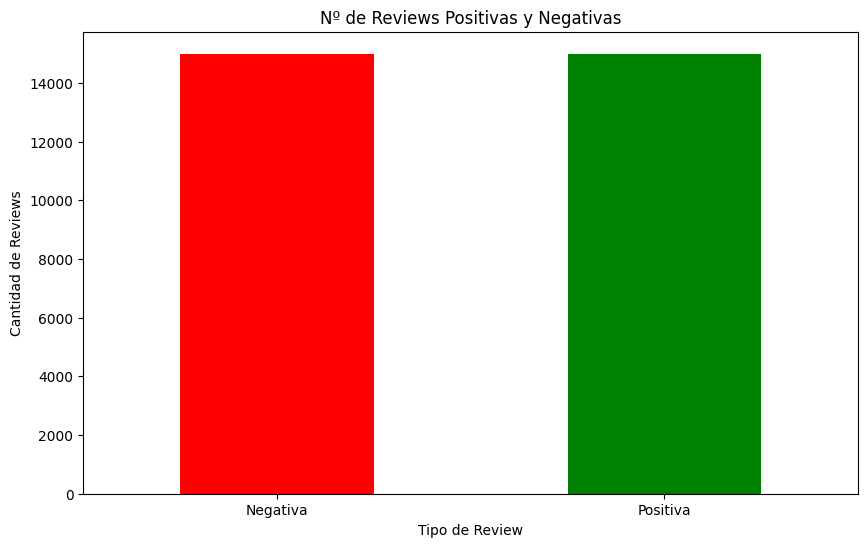

In [14]:
positive_negative_counts = df_corpus['sentimiento'].value_counts().sort_index()
positive_negative_counts.index = ['Negativa', 'Positiva']
print(positive_negative_counts)

positive_negative_counts.plot(kind='bar', figsize=(10, 6), color=['red', 'green'])
plt.title('Nº de Reviews Positivas y Negativas')
plt.xlabel('Tipo de Review')
plt.ylabel('Cantidad de Reviews')
plt.xticks(rotation=0)
plt.show()

In [15]:
# Es normal que salgan 15000 puesto que el número de reviews positivas y negativas que hemos cogido de cada categoría ha sido 5000.

## N-gramas más frecuentes

Bigramas más frecuentes:
[('would recommend', 868), ('much better', 746), ('dont know', 728), ('waste money', 649), ('month old', 609), ('im sure', 598), ('works great', 592), ('even though', 573), ('highly recommend', 564), ('car seat', 562), ('works well', 557), ('first time', 540), ('easy use', 505), ('work well', 488), ('year old', 483), ('make sure', 482), ('thought would', 457), ('every time', 457), ('ive used', 452), ('really like', 447)]

Trigramas más frecuentes:
[('dont waste money', 161), ('goes long way', 132), ('would highly recommend', 112), ('would recommend product', 111), ('would definitely recommend', 108), ('little goes long', 105), ('first time used', 91), ('would recommend anyone', 90), ('pack n play', 89), ('last long time', 82), ('2 year old', 77), ('really wanted like', 76), ('month old son', 67), ('highly recommend product', 66), ('worth every penny', 65), ('doesnt work well', 59), ('6 month old', 58), ('buy another one', 56), ('love love love', 53), ('waste ti

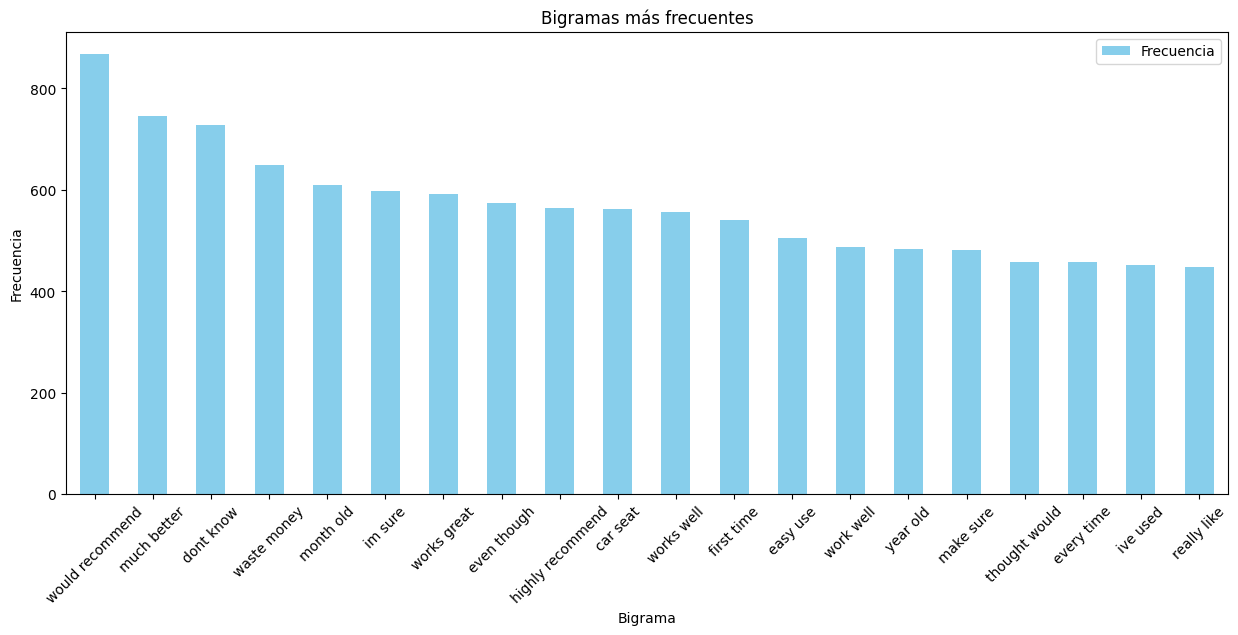

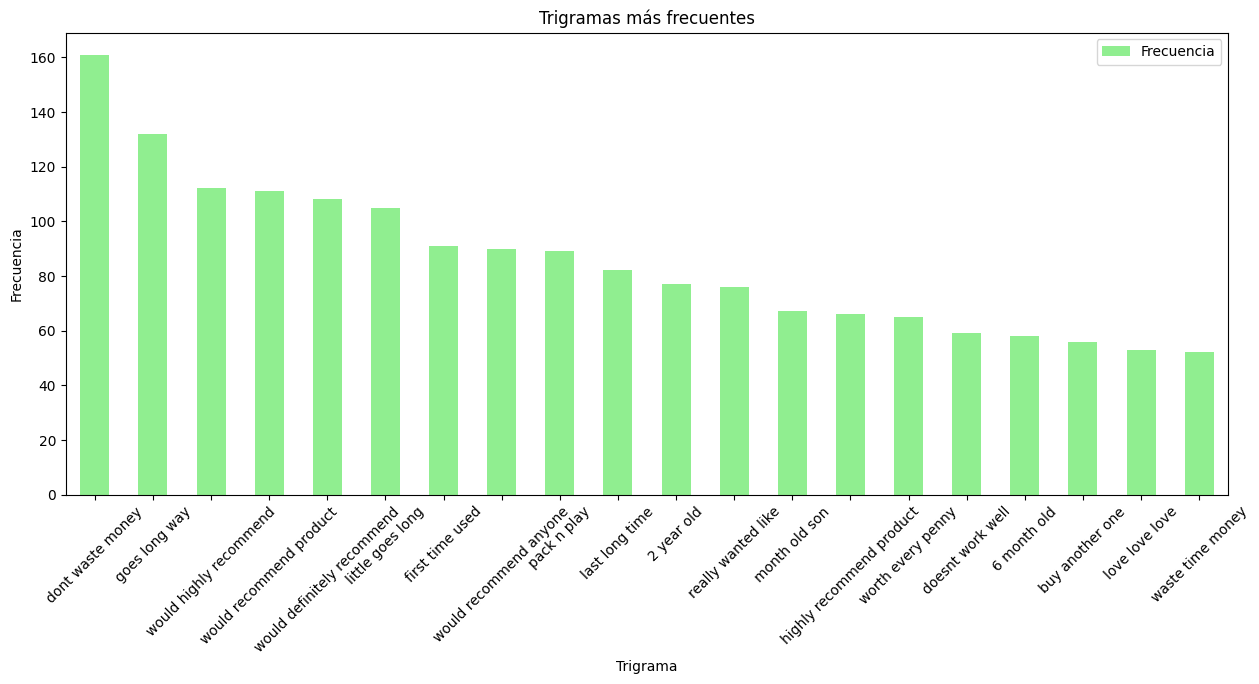

In [16]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    # Elimino stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    return tokens

df_corpus['tokens'] = df_corpus['reviewText'].apply(preprocess_text)

def get_ngrams(tokens, n):
    n_grams = ngrams(tokens, n)
    
    return [' '.join(grams) for grams in n_grams]

def ngram_frequency(df, n, top_k=20):
    all_ngrams = []
    for tokens in df['tokens']:
        all_ngrams.extend(get_ngrams(tokens, n))
    ngram_counts = Counter(all_ngrams)
    
    return ngram_counts.most_common(top_k)

top_bigrams = ngram_frequency(df_corpus, 2)  # Bigramas
top_trigrams = ngram_frequency(df_corpus, 3)  # Trigramas

print("Bigramas más frecuentes:")
print(top_bigrams)
print("\nTrigramas más frecuentes:")
print(top_trigrams)

# Visualización

bigrams_df = pd.DataFrame(top_bigrams, columns=['N-gram', 'Frecuencia'])
bigrams_df.plot(kind='bar', x='N-gram', y='Frecuencia', figsize=(15, 6), color='skyblue')
plt.title('Bigramas más frecuentes')
plt.xlabel('Bigrama')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

trigrams_df = pd.DataFrame(top_trigrams, columns=['N-gram', 'Frecuencia'])
trigrams_df.plot(kind='bar', x='N-gram', y='Frecuencia', figsize=(15, 6), color='lightgreen')
plt.title('Trigramas más frecuentes')
plt.xlabel('Trigrama')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

## Nube de palabras

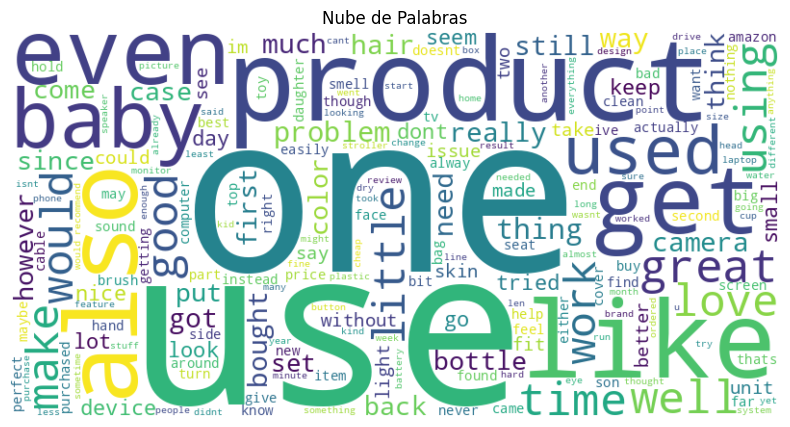

In [17]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    return ' '.join(tokens)

df_corpus['cleaned_text'] = df_corpus['reviewText'].apply(preprocess_text)
all_text = ' '.join(df_corpus['cleaned_text'])

# Creamos la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords.words('english')).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nube de Palabras')
plt.axis('off')
plt.show()

## Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec

Valid words of interest: ['iphone', 'teddy', 'gloss']


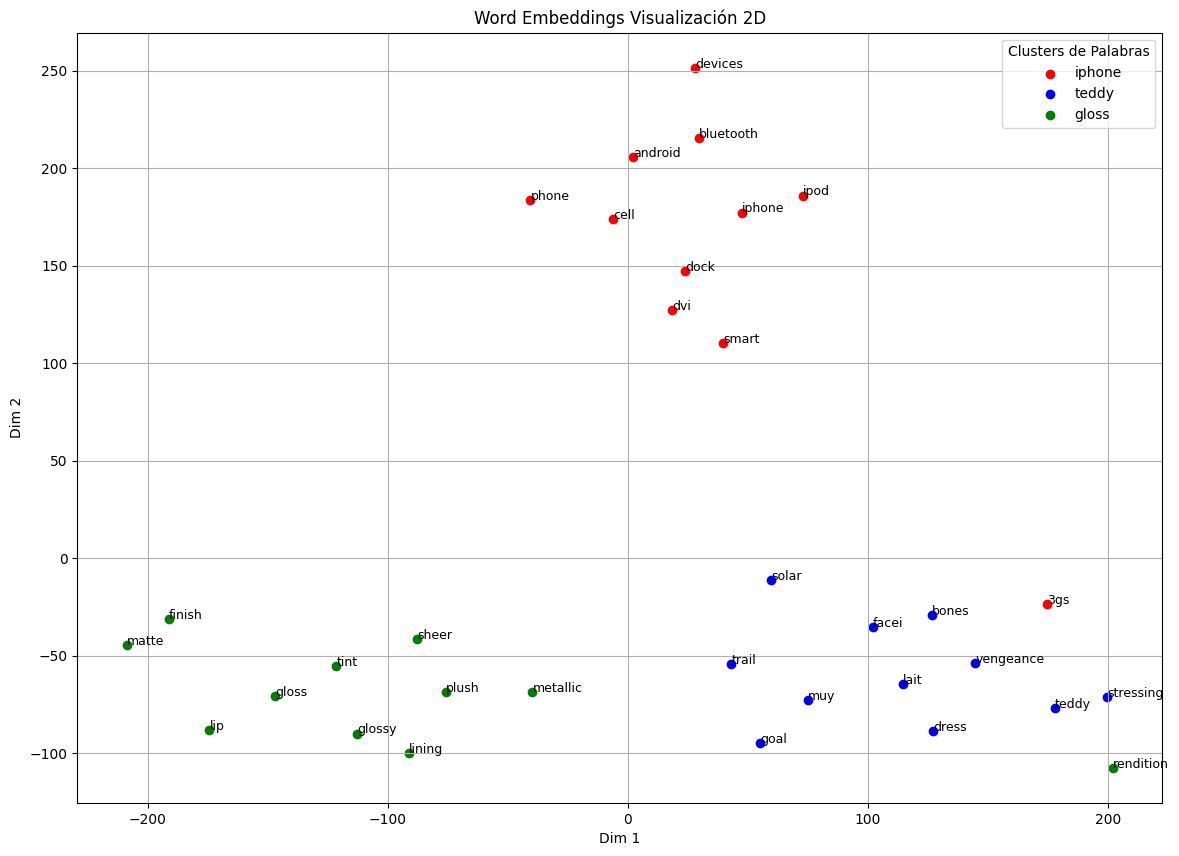

In [18]:
# Entreno  el modelo Word2Vec
model = Word2Vec(sentences=df_corpus['tokens'], vector_size=100, window=5, min_count=5, workers=4)

# Elijo las siguientes palabras de interés para cada categoría 
words_of_interest = ['iphone', 'teddy', 'gloss']

# Valido que las palabras de interés están en el vocabulario
valid_words_of_interest = [word for word in words_of_interest if word in model.wv]
print("Valid words of interest:", valid_words_of_interest)

# Aquí obtengo las top 10 palabras más similares
similar_words = {}
for word in valid_words_of_interest:
    if word in model.wv:
        similar_words[word] = [word] + [w for w, _ in model.wv.most_similar(word, topn=10)]

all_words = sum(similar_words.values(), [])
word_vectors = np.array([model.wv[word] for word in all_words if word in model.wv])

# Reducimos la dimensionalidad a 2D usando TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=5)  # Ajusta la perplejidad si es necesario
word_vectors_2d = tsne.fit_transform(word_vectors)
tsne_df = pd.DataFrame(word_vectors_2d, index=all_words, columns=['x', 'y'])

# Visualización

plt.figure(figsize=(14, 10))
colors = ['red', 'blue', 'green']

for i, (word, words) in enumerate(similar_words.items()):
    indices = [all_words.index(w) for w in words if w in all_words]
    cluster_vectors_2d = word_vectors_2d[indices]
    plt.scatter(cluster_vectors_2d[:, 0], cluster_vectors_2d[:, 1], c=colors[i], label=word)
    for word_index in indices:
        plt.text(word_vectors_2d[word_index, 0] + 0.1, word_vectors_2d[word_index, 1] + 0.1, all_words[word_index], fontsize=9)

plt.title('Word Embeddings Visualización 2D')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.legend(title='Clusters de Palabras')
plt.grid(True)
plt.show()

## Añadido: Análisis de longitud de las reseñas

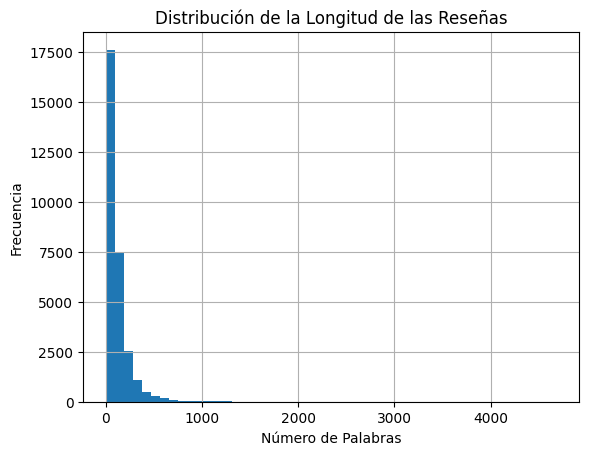

In [19]:
df_corpus['review_length'] = df_corpus['reviewText'].apply(lambda x: len(nltk.word_tokenize(x)))

df_corpus['review_length'].hist(bins=50)
plt.title('Distribución de la Longitud de las Reseñas')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()

In [20]:
# Aquí compruebo que la mayoría de reseñas tienen pocas palabras y no se ven outliers en este sentido

## Añadido: Análisis de la distribución temporal de las reseñas

/var/folders/09/2b6953kn3w559xsdg6bctjbh0000gn/T/ipykernel_73918/1918255451.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_corpus.set_index('reviewTime').resample('M').size().plot()


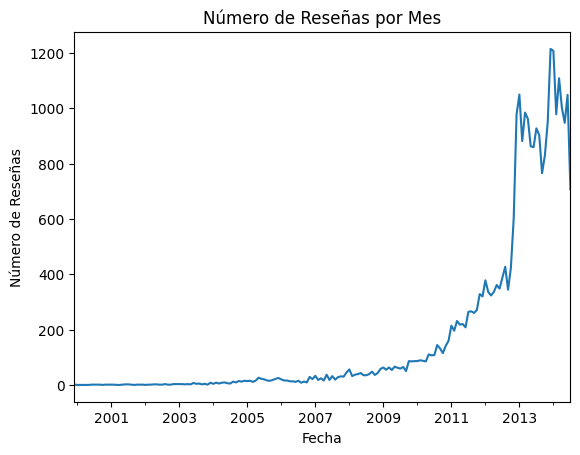

In [21]:
df_corpus['reviewTime'] = pd.to_datetime(df_corpus['reviewTime'])
df_corpus.set_index('reviewTime').resample('M').size().plot()

plt.title('Número de Reseñas por Mes')
plt.xlabel('Fecha')
plt.ylabel('Número de Reseñas')
plt.show()


In [22]:
# Vemos que el número de reseñas ha aumentado considerablemente en los últimos años

## Añadido: Bigramas más frecuentes por sentimiento

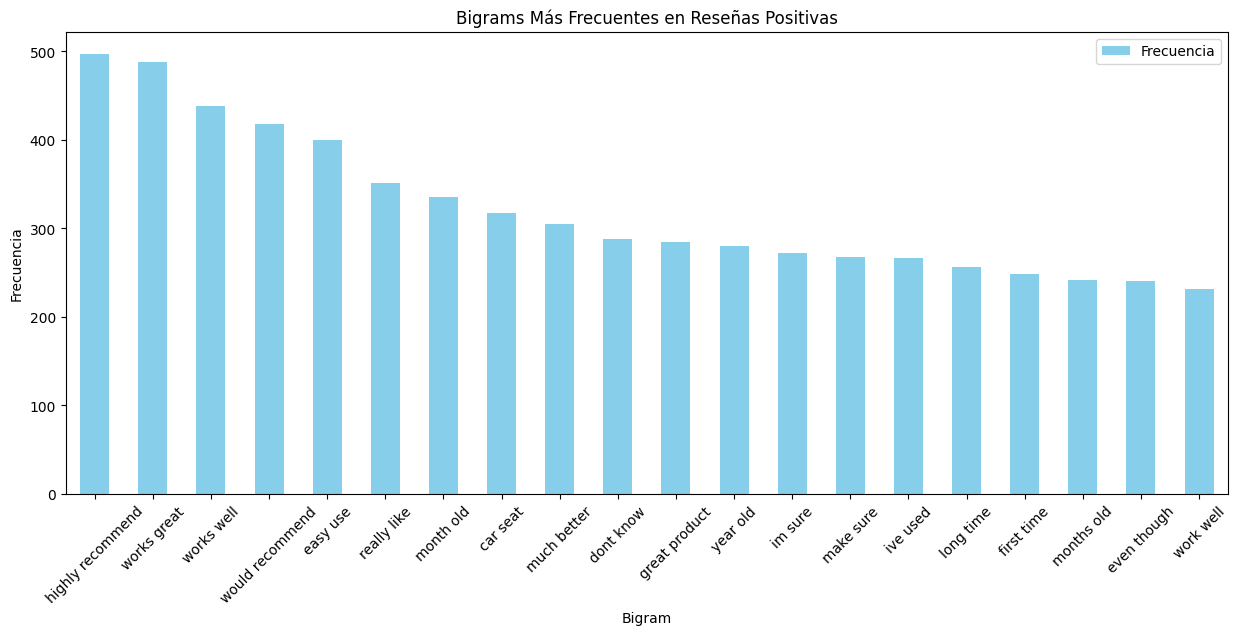

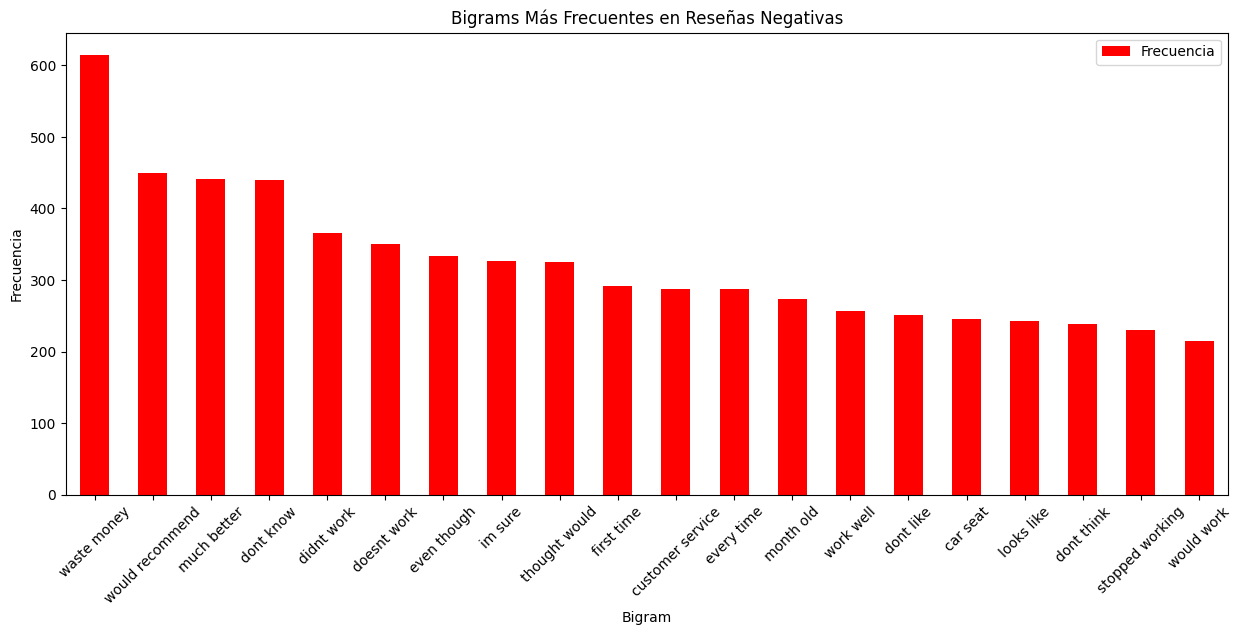

In [23]:
# Podemos ver también los bigramas más frecuentes para cada sentimiento

def ngram_frequency_by_sentiment(df, n, sentiment, top_k=20):
    df_subset = df[df['sentimiento'] == sentiment]
    all_ngrams = []
    for tokens in df_subset['tokens']:
        all_ngrams.extend(get_ngrams(tokens, n))
    
    ngram_counts = Counter(all_ngrams)
    return ngram_counts.most_common(top_k)

top_positive_bigrams = ngram_frequency_by_sentiment(df_corpus, 2, 1)  # Positivas
top_negative_bigrams = ngram_frequency_by_sentiment(df_corpus, 2, 0)  # Negativas

bigrams_df_positive = pd.DataFrame(top_positive_bigrams, columns=['N-gram', 'Frecuencia'])
bigrams_df_positive.plot(kind='bar', x='N-gram', y='Frecuencia', figsize=(15, 6), color='skyblue')
plt.title('Bigrams Más Frecuentes en Reseñas Positivas')
plt.xlabel('Bigram')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Visualizar los bigrams más frecuentes en reseñas negativas
bigrams_df_negative = pd.DataFrame(top_negative_bigrams, columns=['N-gram', 'Frecuencia'])
bigrams_df_negative.plot(kind='bar', x='N-gram', y='Frecuencia', figsize=(15, 6), color='red')
plt.title('Bigrams Más Frecuentes en Reseñas Negativas')
plt.xlabel('Bigram')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()


In [24]:
# Los resultados positivos y negativos parecen lógicos.

Como he decidido hacer ya algo del preproceso como stopwords o quitar signos de puntuación, voy a guardar el corpus final y a ver sus dimensiones para el notebook de preprocesamiento que haremos ahora

In [25]:
df_corpus.shape

(30000, 14)

In [26]:
df_corpus.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,categoría,sentimiento,tokens,cleaned_text,review_length
79688,A2VGK9S4DKTMF,B002V9X78U,BWallace,"[1, 1]",Let's be clear; I love how much I hate this pr...,1,"Lame, even for a white elephant gift",1386720000,2013-12-11,beauty,0,"[lets, clear, love, much, hate, product, bough...",lets clear love much hate product bought white...,121
6611,A1N2EONG2Y6NUZ,B0001EL5R2,Shana,"[0, 0]","This made my skin so greasy and shiny, in addi...",1,Hello greasy skin!,1373587200,2013-07-12,beauty,0,"[made, skin, greasy, shiny, addition, helping,...",made skin greasy shiny addition helping acne d...,23
126995,ANWZD7ZYE50UE,B005MZS03C,Gilberto Prieto,"[0, 5]",i receive the perfume today and they are fake ...,1,FAKE!!!,1379894400,2013-09-23,beauty,0,"[receive, perfume, today, fake, also, bought, ...",receive perfume today fake also bought gucci g...,40
95641,A20RM3LL5IW5JO,B003UZ4R24,Oulzo,"[2, 7]",I got excited after seeing the multiple videos...,1,"Do not buy, the mask is full of alcohol!!!!!!!",1389398400,2014-01-11,beauty,0,"[got, excited, seeing, multiple, videos, youtu...",got excited seeing multiple videos youtube hea...,237
46578,A3E3GD3TABXKU1,B0017TZD7S,Loren w Christensen,"[2, 5]","Maybe I don't get the point with this. Okay, t...",2,don't get its purpose,1215734400,2008-07-11,beauty,0,"[maybe, dont, get, point, okay, use, sex, sell...",maybe dont get point okay use sex sell get sup...,165


In [27]:
df_corpus.to_csv('df_corpus.csv', index=False)

# Conclusiones

- Era evidente que teníamos que hacer un preprocesado de stopwords y puntuación que he decidido hacer en este análisis para tener más claridad en los datos.
- Escoger un subset de 5000 reviews para cada sentimiento parece que es una idea acertada para poder realizar el ejercicio con capacidad computacional.
- De los tokens más repetidos podemos ver que están directamente relacionados con las categorías seleccionadas y los bigramas parecen lógicos.